In [1]:
import sys
import time
import numpy as np
import pandas as pd
sys.path.append("..")
from scipy import stats
from tma.model import Model
from tma.object import Object
from tma.functions import get_df, df_to_docx
from tma.algorithms import swarm
from pathlib import Path
from datetime import datetime
from functools import partial

Создаем модель наблюдателя:

In [2]:
print("Время последнего моделирования:", datetime.now().strftime("%d/%m/%Y %H:%M\n"))

observer_x, observer_y, observer_course, observer_velocity = 0.0, 0.0, 0.0, 6.0
observer = Object('Наблюдатель', observer_x, observer_y, observer_course,
                observer_velocity, verbose=True)

observer.forward_movement(2 * 60)
observer.change_course(270, 'left', omega=0.9)
observer.forward_movement(3 * 60)
observer.change_course(90, 'right', omega=0.9)
observer.forward_movement(2 * 60)

Время последнего моделирования: 08/05/2021 21:51

Наблюдатель движется прямо по курсу 0.0° 120с
Наблюдатель перешёл на курс 270.0° за 100с
Наблюдатель движется прямо по курсу 270.0° 180с
Наблюдатель перешёл на курс 89.99999999999997° за 200с
Наблюдатель движется прямо по курсу 90.0° 120с


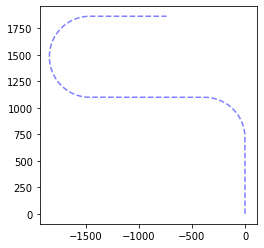

In [3]:
from tma.plot import plot_trajectory
plot_trajectory(observer)

Задаем априорные данные, вектор дистанций, вектор СКО

In [4]:
p0 = [0.0, 25.0, 90.0, 7.0]
std_arr = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0]
d_ranges = [(10, 20), (20, 30), (30, 40), (40, 50), (10, 50)]
def target_func(d1, d2, seed=None):
    rng = np.random.RandomState(seed)
    b = 0
    d = rng.uniform(d1, d2)
    c = rng.uniform(0, 180)
    v = rng.uniform(5, 15)
    return [b, d, c, v]
result_df = pd.DataFrame(columns=[
                                'Диапазон Д0', 'СКО', 
                                'Рэф1', 'Рэф2', 'Рэф3', 'Рэф4', 'Рэф5', 
                                'Ка', 'Вычисления', 'Вычисления макс', 'Итерации', 
                                'Итерации макс', 'Время', 'Время макс',
                                ])
mean_columns = ['Ка', 'Вычисления', 'Итерации', 'Время']
max_columns = ['Вычисления', 'Итерации', 'Время']
new_max_columns = [i + ' макс' for i in max_columns]

Запускаем множество моделей для каждого СКО

In [5]:
%%time
model = Model(observer)
for d_range in d_ranges:
    for std in std_arr:  
        f = partial(target_func, d_range[0], d_range[1])
        model.noise_std = np.radians(std)
        dict_results = swarm(model, algorithm_name='ММП', n=100, target_func=f, p0=p0, seeded=True)
        df = get_df(dict_results)
        df.to_excel('../tests/test7/' 'Траектория 5, ' + str(d_range) + ', ' + str(std) + '.xlsx', index=False)
        res = pd.DataFrame({'СКО': [std], 'Диапазон Д0': [d_range]})
        for i in range(5):
            res['Рэф' + str(i + 1)] = [df['Успех'].apply(lambda x: x[i]).mean(axis=0)]
        res[mean_columns] = df[mean_columns].mean(axis=0)
        res[new_max_columns] = df[max_columns].apply(max, axis=0)
        result_df = result_df.append(res)

Wall time: 23.5 s


In [7]:
result_df['Ка'] = result_df['Ка'].apply(np.sqrt)
result_df.rename(columns={'Ка': 'КKa'}, inplace=True)
result_df.reset_index(drop=True, inplace=True)
Path("../tests/test7").mkdir(parents=True, exist_ok=True)

In [8]:
display_df = result_df.copy()
precisions = {
                'КKa' : '{0:.2f}', 
                'Вычисления' : '{0:.0f}', 
                'Вычисления макс': '{0:.0f}',
                'Итерации' : '{0:.0f}', 
                'Итерации макс' : '{0:.0f}', 
                'Время' : '{0:.4f}', 
                'Время макс' : '{0:.4f}',
            }
for col, precision in precisions.items():
    display_df[col] = display_df[col].apply(lambda x: precision.format(x))
df_to_docx(display_df, f'../tests/test7/Сводная таблица 5.docx')
display_df

,Диапазон Д0,СКО,Рэф1,Рэф2,Рэф3,Рэф4,Рэф5,КKa,Вычисления,Вычисления макс,Итерации,Итерации макс,Время,Время макс
0,"(10, 20)",0.0,1.00,1.00,1.00,1.00,1.00,0.00,15,27,11,20,0.0032,0.0071
1,"(10, 20)",0.1,0.98,1.00,1.00,1.00,1.00,0.10,15,27,11,20,0.0031,0.0066
2,"(10, 20)",0.2,0.95,0.98,0.98,0.99,1.00,0.20,15,27,11,20,0.0032,0.0071
3,"(10, 20)",0.3,0.90,0.96,0.96,0.98,0.98,0.30,15,27,11,20,0.0040,0.0581
4,"(10, 20)",0.5,0.74,0.93,0.93,0.96,0.98,0.50,15,27,11,20,0.0032,0.0063
5,"(10, 20)",1.0,0.41,0.76,0.78,0.89,0.93,1.00,15,27,11,20,0.0031,0.0112
6,"(20, 30)",0.0,1.00,1.00,1.00,1.00,1.00,0.00,8,20,7,15,0.0023,0.0079
7,"(20, 30)",0.1,0.95,0.97,0.97,0.98,1.00,0.10,8,20,7,15,0.0021,0.0052
8,"(20, 30)",0.2,0.81,0.95,0.95,0.96,0.97,0.20,8,20,7,15,0.0020,0.0055
9,"(20, 30)",0.3,0.65,0.92,0.92,0.95,0.96,0.30,8,20,7,15,0.0021,0.0050
